import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import linmix
from linmix.linmix import LinMix
import math

In [2]:
# print([name for _, name, _ in pkgutil.iter_modules(['linmix'])])
help(linmix)
help(LinMix)

Help on package linmix:

NAME
    linmix - A hierarchical Bayesian approach to linear regression with error in both X and Y.

PACKAGE CONTENTS
    linmix

DATA
    __all__ = ['linmix']

FILE
    c:\users\iris reitsma\appdata\roaming\python\python38\site-packages\linmix-0.1.0.dev1-py3.8.egg\linmix\__init__.py


Help on class LinMix in module linmix.linmix:

class LinMix(builtins.object)
 |  LinMix(x, y, xsig=None, ysig=None, xycov=None, delta=None, K=3, nchains=4, parallelize=True, seed=None)
 |  
 |  A class to perform linear regression of `y` on `x` when there are measurement errors in
 |  both variables.  The regression assumes:
 |  
 |  eta = alpha + beta * xi + epsilon
 |  
 |  x = xi + xerr
 |  
 |  y = eta + yerr
 |  
 |  Here, `alpha` and `beta` are the regression coefficients, `epsilon` is the intrinsic random
 |  scatter about the regression, `xerr` is the measurement error in `x`, and `yerr` is the
 |  measurement error in `y`.  `epsilon` is assumed to be normally-distributed

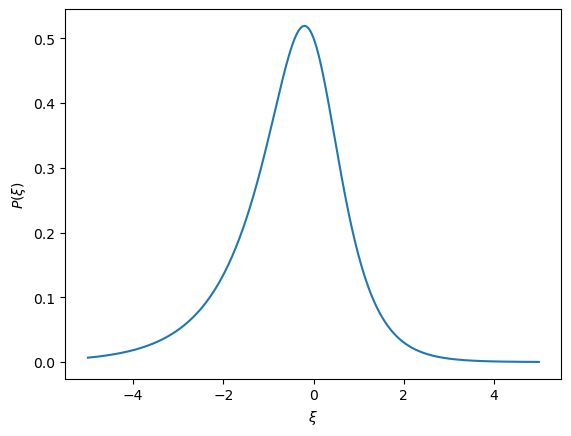

In [3]:
np.random.seed(2)

def pxi(xi):
    return np.exp(xi) * (1.0 + np.exp(2.75*xi))**(-1)
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(-5,5, 0.01)
ax.plot(x, pxi(x))
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$P(\xi)$")
plt.show()

In [4]:
def rejection_sample(p, pmax, prop, size):
    out=[]
    for s in range(size):
        x = prop()
        px = p(x)
        pu = np.random.uniform(low=0.0, high=pmax)
        while px < pu:
            x = prop()
            px = p(x)
            pu = np.random.uniform(low=0.0, high=pmax)
        out.append(x)
    return np.array(out)
pmax = 0.55 # max p(xi) determined by eye
prop = lambda : np.random.uniform(low=-10, high=10) # truncating range to (-10, 10)
xi = rejection_sample(pxi, pmax, prop, size=100)

In [5]:
alpha = 1.0
beta = 0.5
sigsqr = 0.75**2
epsilon = np.random.normal(loc=0, scale=np.sqrt(sigsqr), size=len(xi))
eta = alpha + beta*xi + epsilon

tau = np.std(xi)
sigma = np.sqrt(sigsqr)
t = 0.4 * tau
s = 0.5 * sigma
xsig = 5*t**2 / np.random.chisquare(5, size=len(xi))
ysig =5*s**2 / np.random.chisquare(5, size=len(eta))


x = np.random.normal(loc=xi, scale=xsig)
y = np.random.normal(loc=eta, scale=ysig)
print(len(xsig))
print(len(x))

100
100


In [6]:
lm = linmix.LinMix(x, y, xsig, ysig, K=2, seed=2)


In [7]:
# lm.run_mcmc(silent=False)

In [8]:
# Load in data
tbl = pd.read_csv('preprocessed_data_avg.csv')
display(tbl.head())
# tbl = tbl[tbl['Filter']=='Ks'] # TODO


Unnamed: 0           Source Filter  Obs_number Detected Name    Date obs  \
0           0  RX_J1735.3-3540      J        3081             S  2014-05-07   
1           2  RX_J1735.3-3540      H        3063             S  2014-05-07   
2           4  RX_J1735.3-3540     Ks        3045             S  2014-05-07   
3           6           UW_Crb     Ks        1081             S  2018-06-19   
4           7           UW_Crb      H        1086             S  2018-06-19   

                    RA                 DEC  Error_circle (arcsec)  \
0          17 35 23.75         -35 40 16.1                   0.56   
1          17 35 23.75         -35 40 16.1                   0.56   
2          17 35 23.75         -35 40 16.1                   0.56   
3  16 05 45.8746697208  25 51 45.246497976                   0.10   
4  16 05 45.8746697208  25 51 45.246497976                   0.10   

                 Position_source  ...  log_L_NIR_errup_nodist  \
0              Israel+2008, UVOT  ...                0.003808   
1              Israel+2008, UVOT  ...                0.002848   
2              Israel+2008, UVOT  ...                0.003019   
3  Gaia Collaboration 2020, Gaia  ...                0.051416   
4  Gaia Collaboration 2020, Gaia  ...                0.038230   

   log_L_NIR_errlow_nodist  log_L_NIR_errup_noflux  log_L_NIR_errlow_noflux  \
0                 0.003808                     NaN                      NaN   
1                 0.002848                     NaN                      NaN   
2                 0.003019                     NaN                      NaN   
3                 0.051416                     NaN                      NaN   
4                 0.038230                     NaN                      NaN   

   log_L_X_errup_nodist  log_L_X_errlow_nodist  log_L_X_errup_noflux  \
0              0.108574               0.108574                   NaN   
1              0.108574               0.108574                   NaN   
2              0.108574               0.108574                   NaN   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   

   log_L_X_errlow_noflux  log_L_NIR_upplim  log_L_X_upplim  
0                    NaN               NaN             NaN  
1                    NaN               NaN             NaN  
2                    NaN               NaN             NaN  
3                    NaN               NaN             NaN  
4                    NaN               NaN             NaN  

[5 rows x 67 columns]

C:\Users\Iris Reitsma\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


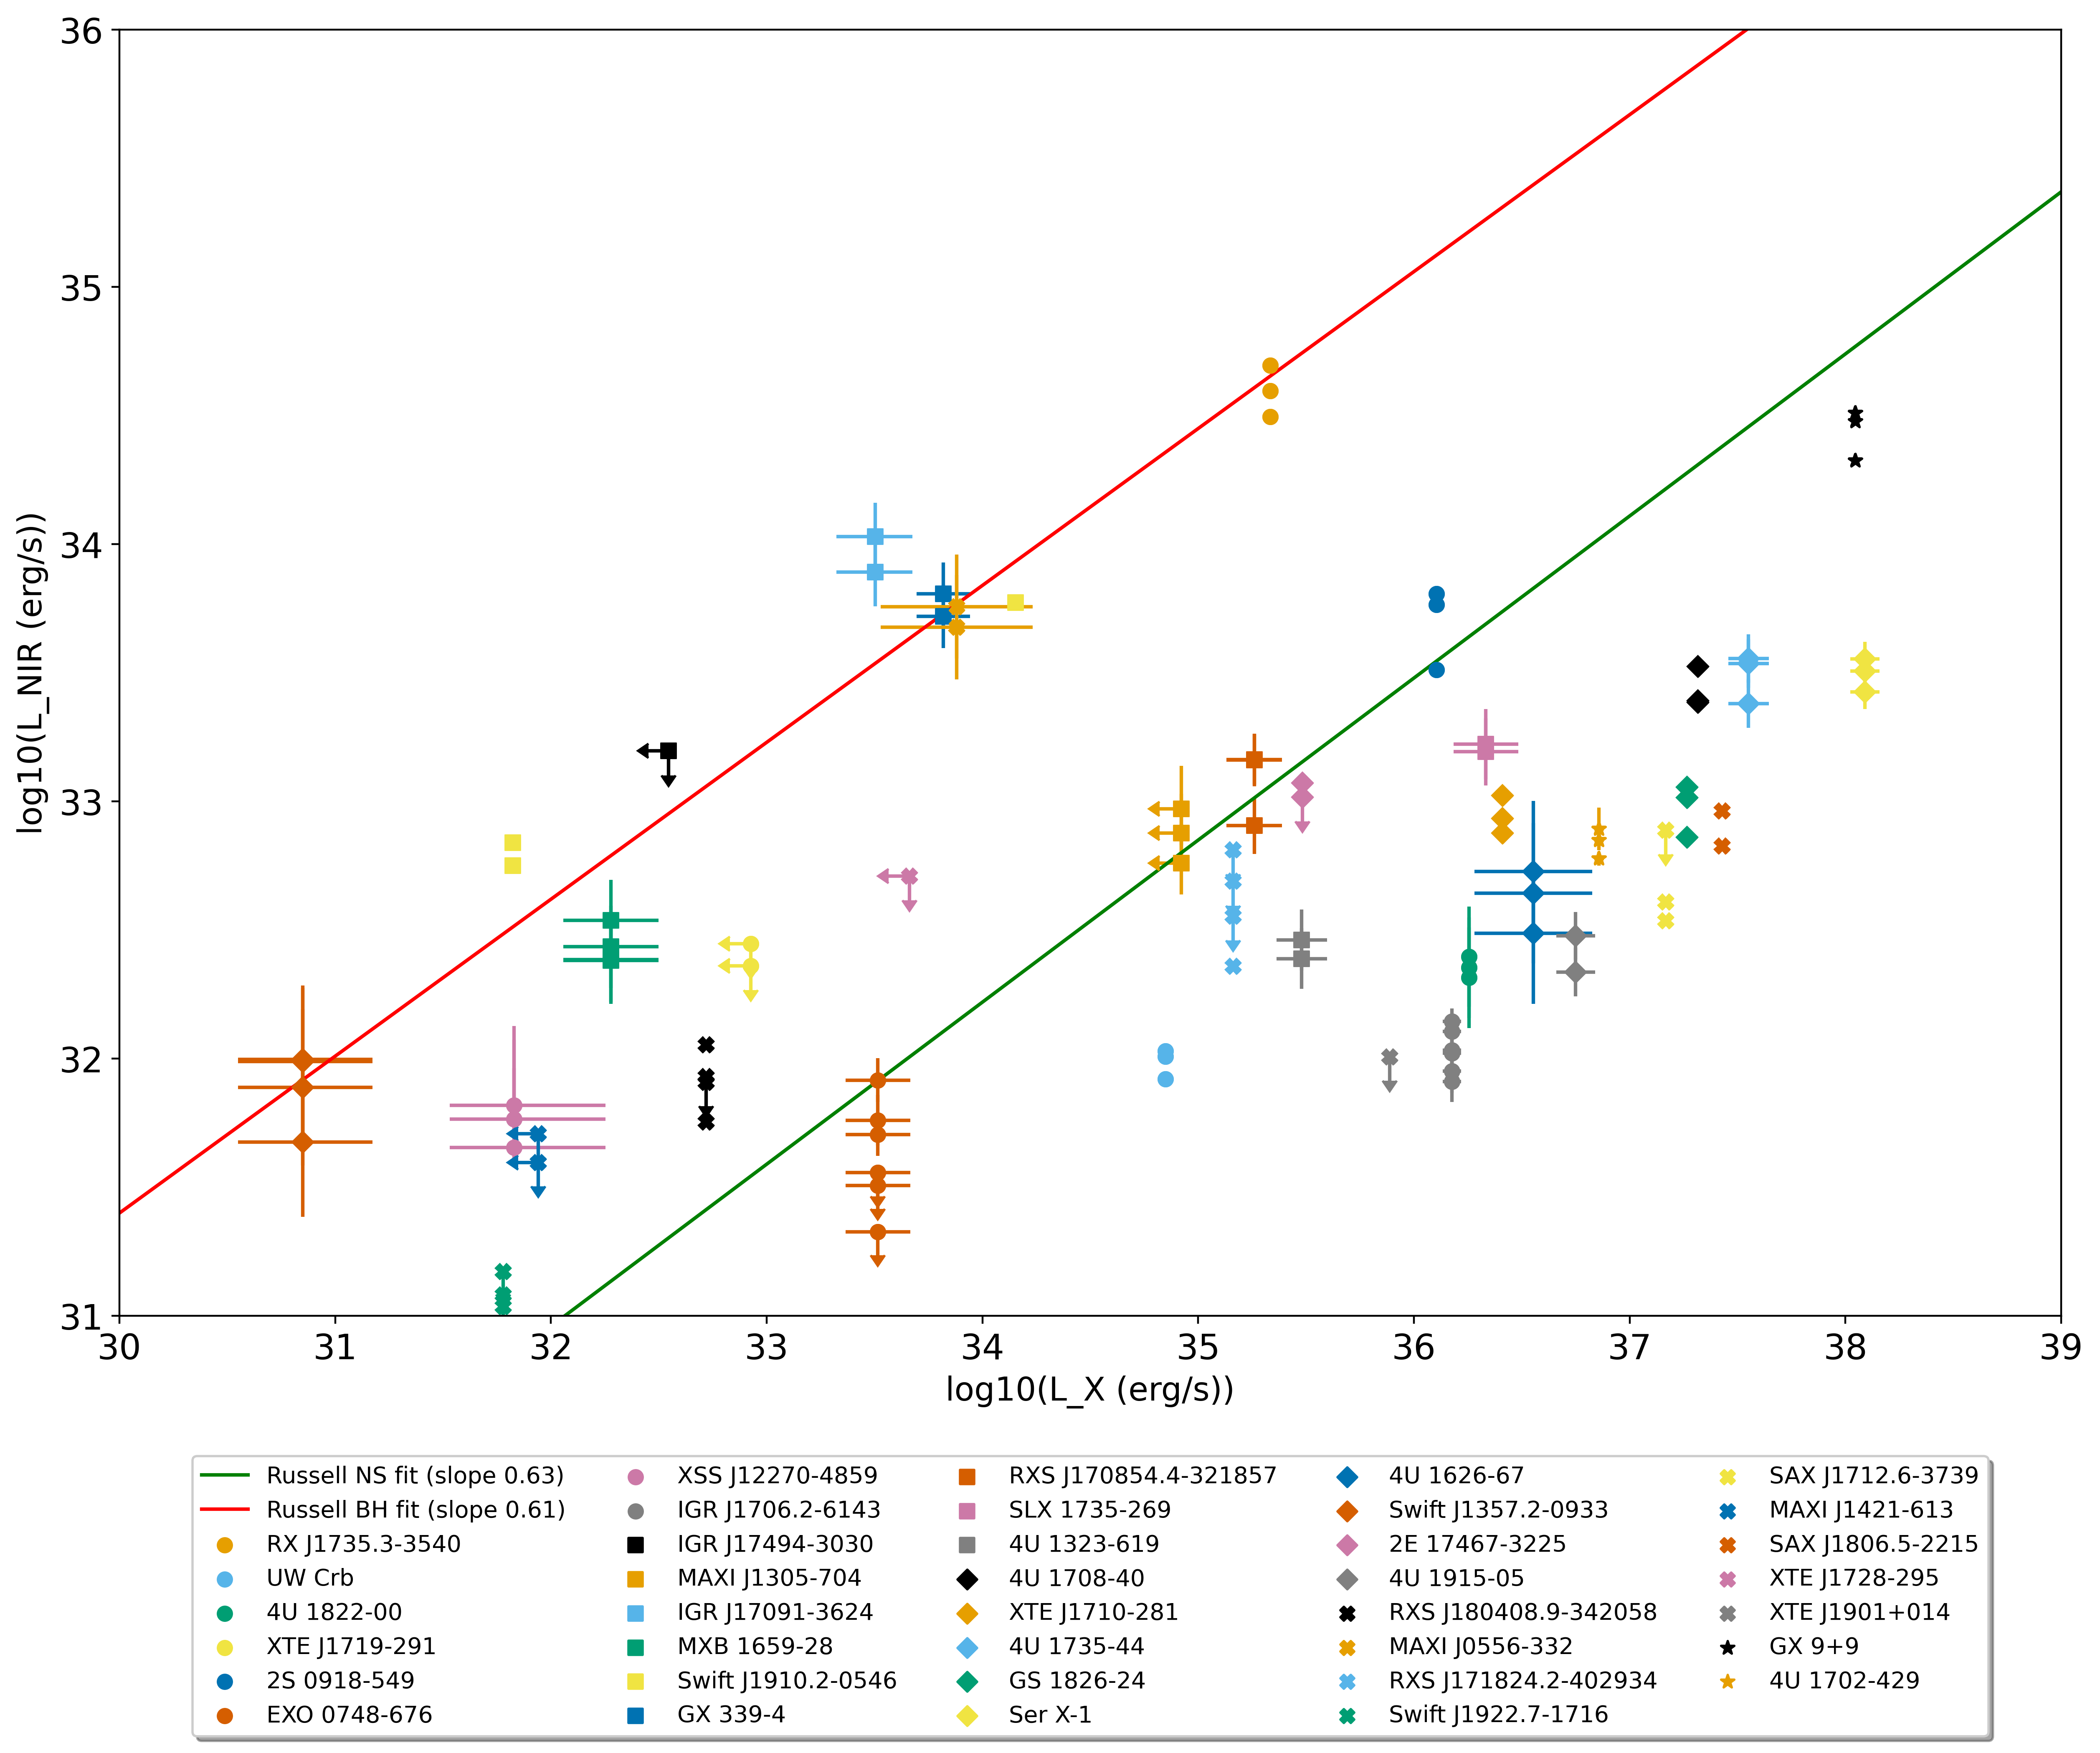

In [9]:
def plotfunc_scatter(ax, tbl, color, shape, label): 
    
    # Remove underscore from labels
    label = label.replace('_', ' ')
    # Plot regular data points 
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10) 
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], [tbl['log_L_NIR_errup']]], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], marker=shape, fmt='o', color=color)

    # Plot points with only upplim on NIR luminosity
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)      
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], uplims = True, marker=shape, fmt='o', color=color)

    # Plot points with only upplim on X-ray luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], tbl[['log_L_NIR_errup']]], xerr=[tbl['log_L_X_upplim']*arrow_scale], xuplims = True, marker=shape, fmt='o', color=color)

    # Plot points with upplims on X-ray luminosity and NIR luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[tbl['log_L_X_upplim']*arrow_scale], uplims=True, xuplims=True, marker=shape,fmt='o', color=color)





    
fig, ax = plt.subplots(figsize = (15, 10), dpi=400)
xrange= np.logspace(29, 41, num=10)
y = 10**10.8 * xrange**(0.63)
ax.plot(np.log10(xrange), np.log10(y), c='g', label='Russell NS fit (slope 0.63)')
y_bh = 10**13.1 * xrange**0.61
ax.plot(np.log10(xrange), np.log10(y_bh), c='r', label='Russell BH fit (slope 0.61)')
markers = ['o', 's', 'D', 'X', '*']
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", 'grey']
options = np.array(np.meshgrid(markers, colors)).T.reshape(-1,2)
# print(options)

arrow_scale = 0.2 / np.log(10) / 30


i = 0
last_source = 'first'
for n, s in enumerate(tbl['Source']):

    # exclude not plotted sources from legend
    if np.isnan(tbl.iloc[n]['L_NIR']) and np.isnan(tbl.iloc[n]['L_NIR_upplim']) or np.isnan(tbl.iloc[n]['L_X']) and np.isnan(tbl.iloc[n]['L_X_upplim']):
        continue
        
    # every source gets a new shape-color combination
    if s != last_source: 
        i +=1
    shape = options[i][0]
    color = options[i][1]
    last_source = s
    
    # scatter plot the data for which luminosites are available
    try: 
        plotfunc_scatter(ax, tbl.iloc[n], color, shape, s)
    except:
        continue
        
ax.set_xlabel('log10(L_X (erg/s))', fontsize=14)
ax.set_ylabel('log10(L_NIR (erg/s))', fontsize=14)
ax.set_xlim(30, 39)
ax.set_ylim(31, 36)
ax.tick_params(axis='both', labelsize=15)

# remove duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [10]:


valid = ~(np.isnan(tbl['L_X']) | np.isnan(tbl['L_NIR']))

x = list(tbl['log_L_X'][valid])
y = list(tbl['log_L_NIR'][valid])
xsig = list(tbl['log_L_X_errlow'][valid])
ysig = list(tbl['log_L_NIR_errlow'][valid])

for n, i in enumerate(xsig):
    if math.isnan(i):
        xsig[n] = 0.1 * x[n]
for n, i in enumerate(ysig):
    if math.isnan(i):
        ysig[n] = 0.1 * y[n]
                

In [11]:
lm = LinMix(x, y, xsig, ysig, K=2, seed=2)


In [12]:
# lm.run_mcmc(silent=False)

AttributeError: 'LinMix' object has no attribute 'chain'

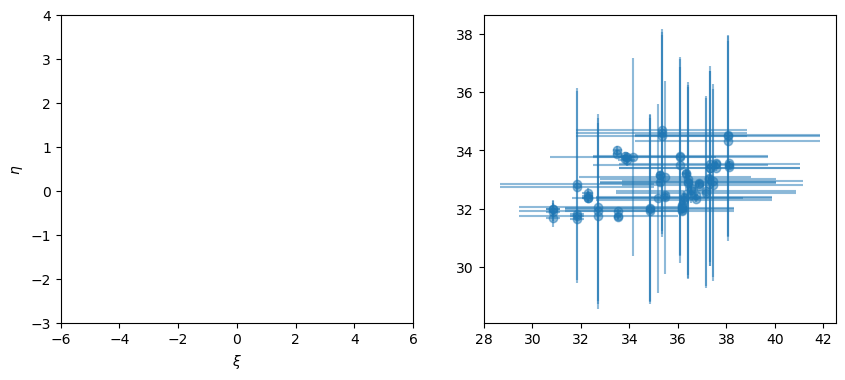

In [13]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
# ax.scatter(xi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_xlim(-6,6)
ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
ax.scatter(x, y, alpha=0.5)
ax.errorbar(x, y, xerr=xsig, yerr=ysig, ls=' ', alpha=0.5)
for i in range(0, len(lm.chain), 25):
    xs = np.arange(30,41)
    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
ys = alpha + xs * beta
ax.plot(xs, ys, color='k')
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(30,40)
ax.set_ylim(30,38)
ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()

In [14]:
plt.scatter(lm.chain['beta'], lm.chain['alpha'], s=0.1)
plt.xlabel('slope')
plt.ylabel('offset')
plt.show()

AttributeError: 'LinMix' object has no attribute 'chain'

In [15]:
states = pd.read_csv('FSRED Mags - total_source_list.csv')

# quiescent/nonquiescent
bhs = states[states['Hard/soft state ']=='quiescence']['Source'].to_list()
BH_tbl = tbl[tbl['Source'].isin(bhs)]
nss = states[states['Hard/soft state ']!='quiescence']['Source'].to_list()
NS_tbl = tbl[tbl['Source'].isin(nss)]

# BH/NS
bhs = states[states['NS/BH']=='BH']['Source'].to_list()
BH_tbl = tbl[tbl['Source'].isin(bhs)]
nss = states[(states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')]['Source'].to_list()
NS_tbl = tbl[tbl['Source'].isin(nss)]

In [16]:

valid_ns = ~(np.isnan(NS_tbl['L_X']) | np.isnan(NS_tbl['L_NIR']))

x_ns = list(NS_tbl['log_L_X'][valid_ns])
y_ns = list(NS_tbl['log_L_NIR'][valid_ns])
xsig_ns = list(NS_tbl['log_L_X_errlow'][valid_ns])
ysig_ns = list(NS_tbl['log_L_NIR_errlow'][valid_ns])

for n, i in enumerate(xsig_ns):
    if math.isnan(i):
        xsig_ns[n] = 0.01 * x_ns[n]
for n, i in enumerate(ysig_ns):
    if math.isnan(i):
        ysig_ns[n] = 0.01 * y_ns[n]

valid_bh = ~(np.isnan(BH_tbl['L_X']) | np.isnan(BH_tbl['L_NIR']))

x_bh = list(BH_tbl['log_L_X'][valid_bh])
y_bh = list(BH_tbl['log_L_NIR'][valid_bh])
xsig_bh = list(BH_tbl['log_L_X_errlow'][valid_bh])
ysig_bh = list(BH_tbl['log_L_NIR_errlow'][valid_bh])

for n, i in enumerate(xsig_bh):
    if math.isnan(i):
        xsig_bh[n] = 0.01 * x_bh[n]
for n, i in enumerate(ysig_bh):
    if math.isnan(i):
        ysig_bh[n] = 0.01 * y_bh[n]
        


In [17]:
print(x_bh[:-1])

[33.50370593413357, 33.50370593413357, 34.15354914455342, 31.823794997627548, 31.823794997627548, 33.81827364390112, 33.81827364390112, 30.849997843885955, 30.849997843885955, 30.849997843885955]


In [18]:
lm_bh = LinMix(x_bh, y_bh, xsig_bh, ysig_bh, K=2, seed=2)
lm_bh.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.072519   1.07069071 1.00461969 1.10531582 1.00434096 0.99123622]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.02102084 1.02117409 1.00725959 1.03026086 1.00091376 1.00674265]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00388678 1.00395175 1.00534516 1.01374455 0.99993428 1.0030782 ]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99967179 0.99991277 1.00241218 1.00646962 0.99992989 1.00364469]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99883749 0.9988074  1.01156583 1.00820612 0.99991418 1.01074802]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99929682 0.9992455  1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00036079 1.00035601 1.00244649 1.00111897 1.00006633 1.00031508]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00038013 1.00037741 1.00247938 1.00130311 1.00006449 1.00039754]


In [19]:
np.save('pickles/alphas_bh.npy', lm_bh.chain['alpha'])
np.save('pickles/betas_bh.npy', lm_bh.chain['beta'])

In [20]:
lm_ns = LinMix(x_ns, y_ns, xsig_ns, ysig_ns, K=2, seed=2)
lm_ns.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99870046 0.99967232 1.00050788 0.99995086 0.99696555 0.99453095]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00016497 1.00040434 1.00055554 0.99843062 0.99734187 0.99761171]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99986881 0.99987312 1.00397024 0.99708231 1.00184779 1.00276596]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00172025 1.00165639 1.00145704 0.99795855 1.00219962 1.00541879]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00153356 1.00139865 0.99966754 0.99976869 1.00126214 1.00308556]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99885863 0.99885001 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99998742 0.99998453 0.99988119 1.00112211 0.99991225 0.99998877]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99997088 0.99996669 0.99987663 1.00111312 0.99992101 0.9999957 ]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99992537 0.99992044 0.99989366 1.00109976 0.99992858 0.99997209]


In [21]:
np.save('pickles/alphas_ns.npy', lm_ns.chain['alpha'])
np.save('pickles/betas_ns.npy', lm_ns.chain['beta'])

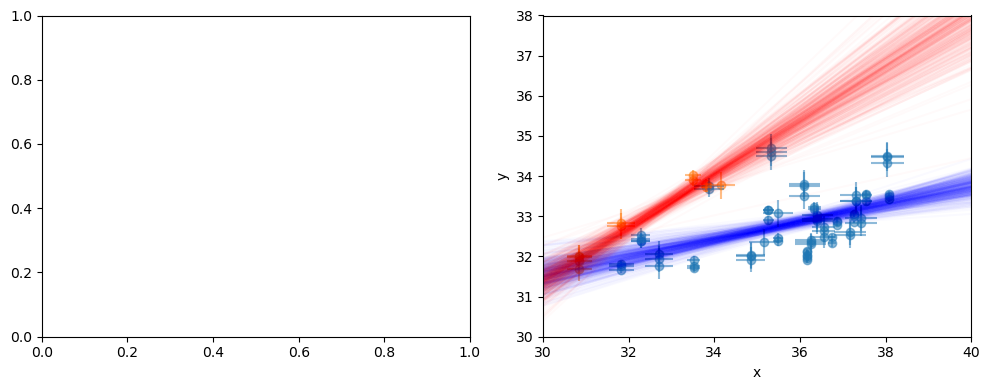

In [22]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
# ax.scatter(xi, eta)
# ax.set_xlabel(r'$\xi$')
# ax.set_ylabel(r'$\eta$')
# ax.set_xlim(-6,6)
# ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
ax.scatter(x_ns, y_ns, alpha=0.5)
ax.errorbar(x_ns, y_ns, xerr=xsig_ns, yerr=ysig_ns, ls=' ', alpha=0.5)
ax.scatter(x_bh, y_bh, alpha=0.5, color='C1')
ax.errorbar(x_bh, y_bh, xerr=xsig_bh, yerr=ysig_bh, ls=' ', alpha=0.5, color='C1')
for i in range(0, len(lm_ns.chain), 25):
    xs = np.arange(30,41)
    ys = lm_ns.chain[i]['alpha'] + xs * lm_ns.chain[i]['beta']
    ax.plot(xs, ys, color='b', alpha=0.02)
for i in range(0, len(lm_bh.chain), 25):
    xs = np.arange(30,41)
    ys = lm_bh.chain[i]['alpha'] + xs * lm_bh.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
# ys = alpha + xs * beta
# ax.plot(xs, ys, color='k')
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(30,40)
ax.set_ylim(30,38)
# ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()

In [25]:
print(np.mean(lm_bh.chain['beta']), np.std(lm_bh.chain['beta']))
print(np.mean(lm_ns.chain['beta']), np.std(lm_ns.chain['beta']))

0.661827595154536 0.09392930791997554
0.22143095392587275 0.0449864223112504


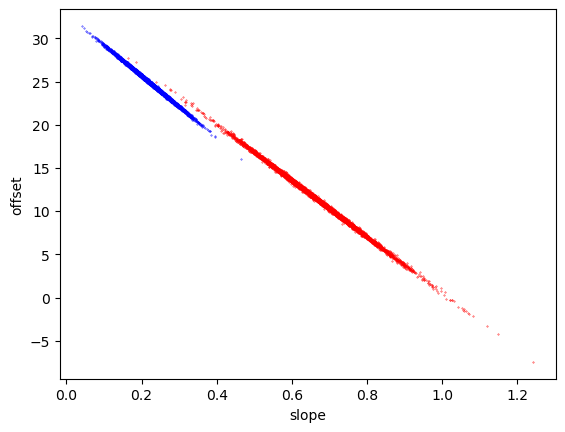

In [23]:
plt.scatter(lm_bh.chain['beta'], lm_bh.chain['alpha'], s=0.1, color='r')
plt.scatter(lm_ns.chain['beta'], lm_ns.chain['alpha'], s=0.1, color='b')
plt.xlabel('slope')
plt.ylabel('offset')
plt.show()